import required libs

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from tqdm.autonotebook import tqdm
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
import matplotlib.dates as mdates

# Let's parse the financial TS data from the crypto market

In [2]:
def get_info(ticker_obj):
    info_keys = ['shortName']
    info_values = []
    for key in info_keys:
        info_values.append(ticker_obj.info.get(key, None))
    return dict(zip(info_keys, info_values))

In [3]:
interesting_tickers = ['BTC-USD','ETH-USD', 'SOL-USD', 'BNB-USD', 'XRP-USD', 'DOGE-USD', 'ADA-USD', 'TRX-USD', 'XLM-USD', 'AVAX-USD',
                       'TON-USD', 'TWT-USD', 'DOT-USD', 'LINK-USD', 'BCH-USD', 'NEAR-USD', 'LEO-USD', 'LTC-USD', 'HBAR-USD', 'ELF-USD',
                       'CRO-USD', 'MATIC-USD', 'ETC-USD','VET-USD', 'FIL-USD', 'ATOM-USD', 'OM-USD', 'OKB-USD', 'XMR-USD', 'INJ-USD',
                       'AAVE-USD', 'FTM-USD', 'ALGO-USD', 'TWT-USD', 'CAKE-USD', 'THETA-USD', 'RUNE-USD', 'CRV-USD', 'HEX-USD', 'MKR-USD',
                       'AR-USD', 'KSM-USD', 'XTZ-USD', 'SAND-USD', 'QNT-USD', 'KCS-USD', 'GLM-USD', 'EOS-USD', 'FET-USD', 'MANA-USD']
load = True

if load:
    full_ticker_data = []
    for ticker in tqdm(interesting_tickers):  #tqdm - helps to understand how much is already done (visual loading bar)
        try:
            ticker_obj = yf.Ticker(ticker)
            price = ticker_obj.history(period='1mo', interval='15m') #1mo = 36points (ideally 50mo - but 3 tokens don't have 1-2 month for it)
            pct_change = (price['Close'] - price['Open'])/price['Open']
            close_price_dict = pct_change.to_dict()
            full_ticker_data.append(close_price_dict)
        except Exception as e:
            print(e)
            continue
        
    funds_0 = pd.DataFrame(full_ticker_data)
    funds_0.insert(0, "shortName", interesting_tickers)

100%|██████████| 50/50 [01:31<00:00,  1.84s/it]


In [4]:
display(funds_0.head())
funds_0.shape

,shortName,2024-11-21 14:30:00+00:00,2024-11-21 14:45:00+00:00,2024-11-21 15:00:00+00:00,2024-11-21 15:15:00+00:00,2024-11-21 15:30:00+00:00,2024-11-21 15:45:00+00:00,2024-11-21 16:00:00+00:00,2024-11-21 16:15:00+00:00,2024-11-21 16:30:00+00:00,2024-11-21 16:45:00+00:00,2024-11-21 17:00:00+00:00,2024-11-21 17:15:00+00:00,2024-11-21 17:30:00+00:00,2024-11-21 17:45:00+00:00,2024-11-21 18:00:00+00:00,2024-11-21 18:15:00+00:00,2024-11-21 18:30:00+00:00,2024-11-21 18:45:00+00:00,2024-11-21 19:00:00+00:00,2024-11-21 19:15:00+00:00,2024-11-21 19:30:00+00:00,2024-11-21 19:45:00+00:00,2024-11-21 20:00:00+00:00,2024-11-21 20:15:00+00:00,2024-11-21 20:30:00+00:00,2024-11-21 20:45:00+00:00,2024-11-21 21:00:00+00:00,2024-11-21 21:15:00+00:00,2024-11-21 21:30:00+00:00,2024-11-21 21:45:00+00:00,2024-11-21 22:00:00+00:00,2024-11-21 22:15:00+00:00,2024-11-21 22:30:00+00:00,2024-11-21 22:45:00+00:00,2024-11-21 23:00:00+00:00,2024-11-21 23:15:00+00:00,2024-11-21 23:30:00+00:00,2024-11-21 23:45:00+00:00,2024-11-22 00:00:00+00:00,...,2024-12-21 04:45:00+00:00,2024-12-21 05:00:00+00:00,2024-12-21 05:15:00+00:00,2024-12-21 05:30:00+00:00,2024-12-21 05:45:00+00:00,2024-12-21 06:00:00+00:00,2024-12-21 06:15:00+00:00,2024-12-21 06:30:00+00:00,2024-12-21 06:45:00+00:00,2024-12-21 07:00:00+00:00,2024-12-21 07:15:00+00:00,2024-12-21 07:30:00+00:00,2024-12-21 07:45:00+00:00,2024-12-21 08:00:00+00:00,2024-12-21 08:15:00+00:00,2024-12-21 08:30:00+00:00,2024-12-21 08:45:00+00:00,2024-12-21 09:00:00+00:00,2024-12-21 09:15:00+00:00,2024-12-21 09:30:00+00:00,2024-12-21 09:45:00+00:00,2024-12-21 10:00:00+00:00,2024-12-21 10:15:00+00:00,2024-12-21 10:30:00+00:00,2024-12-21 10:45:00+00:00,2024-12-21 11:00:00+00:00,2024-12-21 11:15:00+00:00,2024-12-21 11:30:00+00:00,2024-12-21 11:45:00+00:00,2024-12-21 12:00:00+00:00,2024-12-21 12:15:00+00:00,2024-12-21 12:30:00+00:00,2024-12-21 12:45:00+00:00,2024-12-21 13:00:00+00:00,2024-12-21 13:15:00+00:00,2024-12-21 13:30:00+00:00,2024-12-21 13:45:00+00:00,2024-12-21 14:00:00+00:00,2024-12-21 14:15:00+00:00,2024-12-21 14:30:00+00:00
0,BTC-USD,-0.001101,-0.001722,-0.001635,-0.004036,-0.000941,0.006661,-0.002289,0.003649,0.000316,-0.000498,0.000772,0.003468,0.000276,0.002724,0.000251,0.002551,-0.002106,0.001738,0.003184,-0.002061,-0.003383,-0.003598,0.006181,0.003935,-0.006625,0.001800,-0.001245,-0.002145,-0.002051,0.001245,-0.000457,0.001827,0.000444,0.001146,0.001835,-0.001079,0.001425,-0.000889,-0.001428,...,0.000548,0.001144,-0.001377,0.003151,0.007578,0.001306,-0.003463,0.000919,0.001528,-0.000212,0.002447,0.006137,-0.002938,-0.000743,-0.003195,-0.001492,0.002095,-0.001262,-0.000211,-0.000410,0.001818,0.000461,-0.000979,-0.002838,-0.001418,-0.000441,-0.003002,0.004103,-0.000293,-0.003547,-0.000052,-0.002847,-0.003741,0.002965,-0.007912,0.008942,0.001245,0.002044,-0.000882,NaN
1,ETH-USD,-0.006180,0.002466,-0.007937,-0.012106,0.002721,0.001158,0.004346,0.004371,0.003716,-0.001189,-0.004539,0.005913,0.004178,-0.001482,0.000649,-0.000241,0.000981,0.005985,-0.001328,-0.009685,0.000587,-0.003092,0.002946,0.000269,-0.006280,0.003007,-0.001834,-0.001575,-0.002107,0.000042,0.006873,-0.000421,0.001548,0.000996,-0.003407,0.000762,0.000396,-0.002946,0.002998,...,0.001004,0.002293,-0.003294,0.003647,0.010088,-0.000284,-0.004352,0.001235,0.002376,0.002503,0.003722,0.001497,-0.005623,-0.001941,-0.005097,-0.003385,0.001174,-0.004421,0.000323,0.000539,0.002371,0.000754,0.002301,-0.010237,0.000121,-0.001247,-0.009587,0.005054,-0.000434,-0.006969,0.000556,-0.002886,0.001336,0.002038,-0.013733,0.009619,-0.000528,0.005129,-0.003111,0.0
2,SOL-USD,-0.009270,0.031788,-0.016114,-0.013211,0.004583,0.012872,0.001435,0.000661,0.004625,0.013407,-0.002201,0.010108,0.004613,-0.001765,-0.003182,0.005341,-0.001409,0.002061,-0.002268,-0.011011,-0.001968,-0.003666,0.007557,0.002194,-0.010274,0.002403,-0.004034,0.000867,0.000848,-0.002842,0.003696,-0.000589,0.003813,0.000478,0.001692,0.003509,0.002711,-0.000705,-0.000958,...,0.001865,0.007061,-0.003486,0.0017

(50, 2882)

In [5]:
funds_0.isna().sum(axis=1)

0     1
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    1
11    0
12    0
13    0
14    0
15    1
16    1
17    0
18    0
19    1
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
dtype: int64

Prepare the data for clustering 

In [6]:
funds_0.index = funds_0['shortName']
funds_0.drop(columns='shortName', inplace=True)
funds_0.drop(columns=funds_0.columns[-1], inplace=True)

# Define the optimal number of clusters according to Elbow method

100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


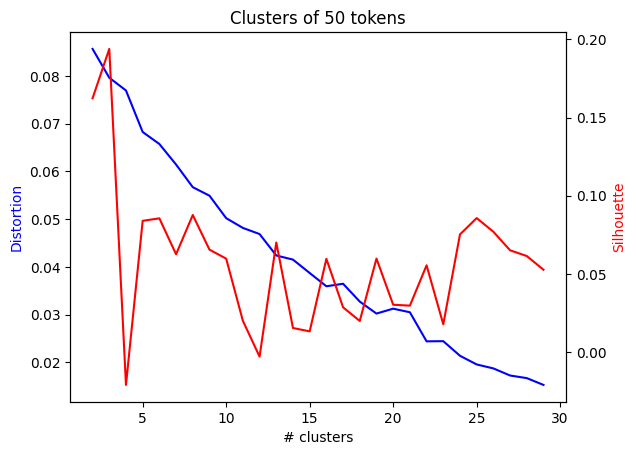

In [31]:
distortions = []
silhouette = []
K = range(2,30)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k)
    kmeanModel.fit(funds_0)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(funds_0, kmeanModel.labels_, metric="euclidean"))

fig, ax1 = plt.subplots()
plt.title("Clusters of 50 tokens")

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('# clusters')
ax1.set_ylabel('Distortion', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()  # Elbow method - helps to determine how many clusters are needed and possible to make

# Predicting the cluster for each token

In [32]:
n_clusters = 4
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=-1, max_iter=10)
ts_kmeans.fit(funds_0)

TimeSeriesKMeans(max_iter=10, n_clusters=4, n_jobs=-1)

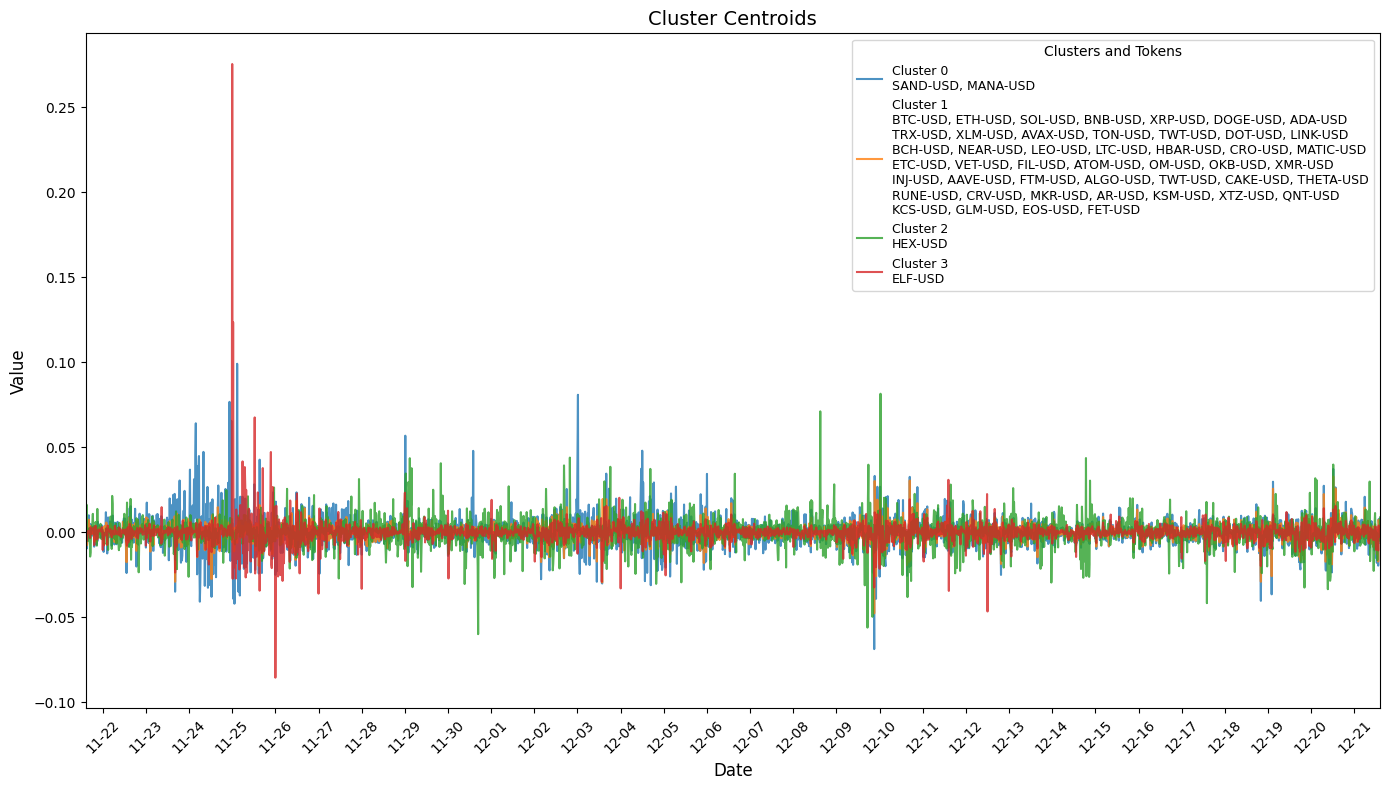

In [33]:
dates = pd.to_datetime(funds_0.columns)
n_clusters = ts_kmeans.n_clusters

cluster_tokens = {cluster: [] for cluster in range(n_clusters)}

for token, label in zip(funds_0.index, ts_kmeans.labels_):
    cluster_tokens[label].append(token)

def format_tokens(tokens, max_per_line=7):
    return "\n".join([", ".join(tokens[i:i + max_per_line]) for i in range(0, len(tokens), max_per_line)])

plt.figure(figsize=(14, 8))

for cluster_number in range(n_clusters):
    plt.plot(
        dates,  
        ts_kmeans.cluster_centers_[cluster_number, :, 0].T,
        label=f"Cluster {cluster_number}\n{format_tokens(cluster_tokens[cluster_number])}",
        alpha=0.8
    )

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
plt.gca().xaxis.set_minor_locator(mdates.DayLocator())

plt.xlim(dates[0], dates[-1])
plt.title("Cluster Centroids", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value", fontsize=12)

plt.legend(
    loc='upper right',
    title="Clusters and Tokens",
    fontsize=9,
    title_fontsize=10
)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Thanks for watching!

# Homework:
1. Look forward to your final project on one of the topics we discussed in class!